# Introduction
---
In this assignment, we will try to find the best model for a given dataset.
We will perform the following stages:
1. Import the data
2. Preliminary data analysis
3. Preprocessing
4. Trying different models
5. Balancing the data
6. Grid search for the best hyperparameters

We will choose between the following classification models __learned in class so far__:
- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost

In [50]:
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
import statistics
from sklearn.base import clone
from tqdm import tqdm
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt


# 1. Import the Data set
---

In [2]:
## Load the data
with open('../../data/ass3.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
## Example of train samples
df = pd.DataFrame(data['train'])
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,target
14981,4.0391,15.0,6.297710,0.992366,334.0,2.549618,32.72,-116.99,1.695
6614,4.7241,46.0,5.375758,0.954545,753.0,2.281818,34.17,-118.10,2.796
14233,3.3553,7.0,5.229213,1.101124,1304.0,2.930337,32.70,-117.01,1.322
1802,1.3929,52.0,5.000000,0.953488,126.0,2.930233,37.92,-122.36,1.042
6030,1.6006,52.0,4.427083,1.017361,1246.0,2.163194,34.07,-117.75,1.462


#### Extract train, dev, test datasets (x and y)

In [4]:
## Get train dev test Xs and ys (X type is dataFrame and y type is Series)
df_train = data['train']
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

df_dev = data['dev']
X_dev = df_dev.iloc[:, :-1]
y_dev = df_dev.iloc[:, -1]

df_test = data['test']
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 2. Preliminary data analysis
---
In this section, we will analyze the data and try to understand it better.
We will focus on the following:
- What is the problem type? (classification/regression)
- What is the data distribution?
- What is the data range?
- Are there missing values?
- What is the correlation between the features?
- What is the correlation between each feature and the label?
- What is the distribution of each feature?

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12384, 8)
X_dev shape: (4128, 8)
X_test shape: (4128, 8)


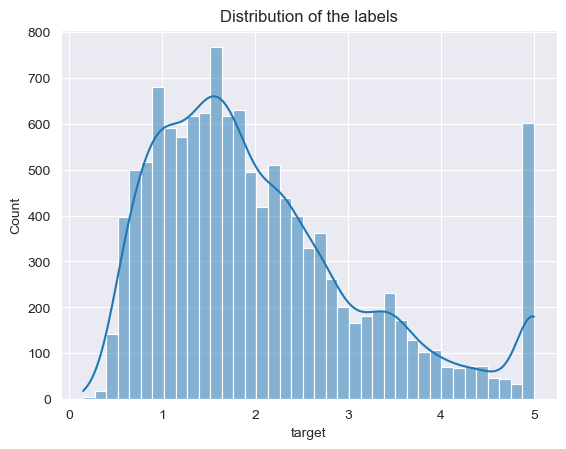

In [21]:
# show the distribution of the labels given it is a regression problem
# add a trend line
sns.histplot(y_train, kde=True)
plt.title('Distribution of the labels')
plt.show()

We can see that the train labels are distributed normally, with an anomaly at the end.

## Missing values

In [24]:
# check the number of missing values
print(f"Number of missing values in train: {X_train.isnull().sum().sum()}")

Number of missing values in train: 1238


In [25]:
# where are the missing values?
X_train.isnull().sum()


f0    174
f1    140
f2    158
f3    156
f4    169
f5    142
f6    151
f7    148
dtype: int64

In [26]:
# check in which examples the missing values are
X_train[X_train.isnull().any(axis=1)]


,f0,f1,f2,f3,f4,f5,f6,f7
19195,3.4545,36.0,4.891791,0.966418,648.0,2.417910,38.44,NaN
4231,NaN,52.0,5.174917,1.113861,1213.0,2.001650,34.11,-118.30
19943,1.9355,10.0,5.136555,1.105042,1262.0,2.651261,NaN,-119.36
18650,NaN,37.0,6.572748,1.277136,939.0,2.168591,36.88,-121.96
526,3.0161,52.0,4.673721,0.998236,NaN,2.589065,37.77,-122.25
...,...,...,...,...,...,...,...,...
3099,3.3269,15.0,NaN,1.122807,1245.0,2.426901,35.65,-117.68
13194,3.2344,14.0,5.248731,1.124365,2026.0,2.571066,34.08,NaN
9283,5.6150,27.0,6.678373,NaN,4406.0,2.714726,38.08,-122.58
6951,3.0577,NaN,4.854839,1.016129,1002.0,4.040323,33.99,-118.07


There are a lot of missing values in the data, spread across the different features and rows. We will deal with them in the preprocessing section.
methods to handle it:
- remove the rows with missing values (not relevant in this case because a lot of rows will be removed)
- insert mean/median/mode instead of the missing values
- use a model to predict the missing values
- use a model that can handle missing values (e.g. XGBoost)
- add a new feature that indicates if the value is missing or not

## Data range and correlation

In [30]:
# show the range of the data
X_train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7
count,12210.000000,12244.000000,12226.000000,12228.000000,12215.000000,12242.000000,12233.000000,12236.000000
mean,3.872771,28.630595,5.420978,1.096626,1426.830618,3.144714,35.626833,-119.561040
std,1.919183,12.566127,2.382548,0.471398,1103.528284,13.440452,2.133539,1.996646
min,0.499900,1.000000,0.846154,0.500000,3.000000,0.692308,32.550000,-124.350000
25%,2.555600,18.000000,4.430232,1.006386,786.000000,2.428571,33.940000,-121.790000
50%,3.534100,29.000000,5.218429,1.049202,1170.000000,2.816384,34.250000,-118.490000
75%,4.745975,37.000000,6.043349,1.099202,1739.000000,3.276456,37.710000,-118.020000
max,15.000100,52.000000,132.533333,34.066667,28566.000000,1243.333333,41.950000,-114.550000


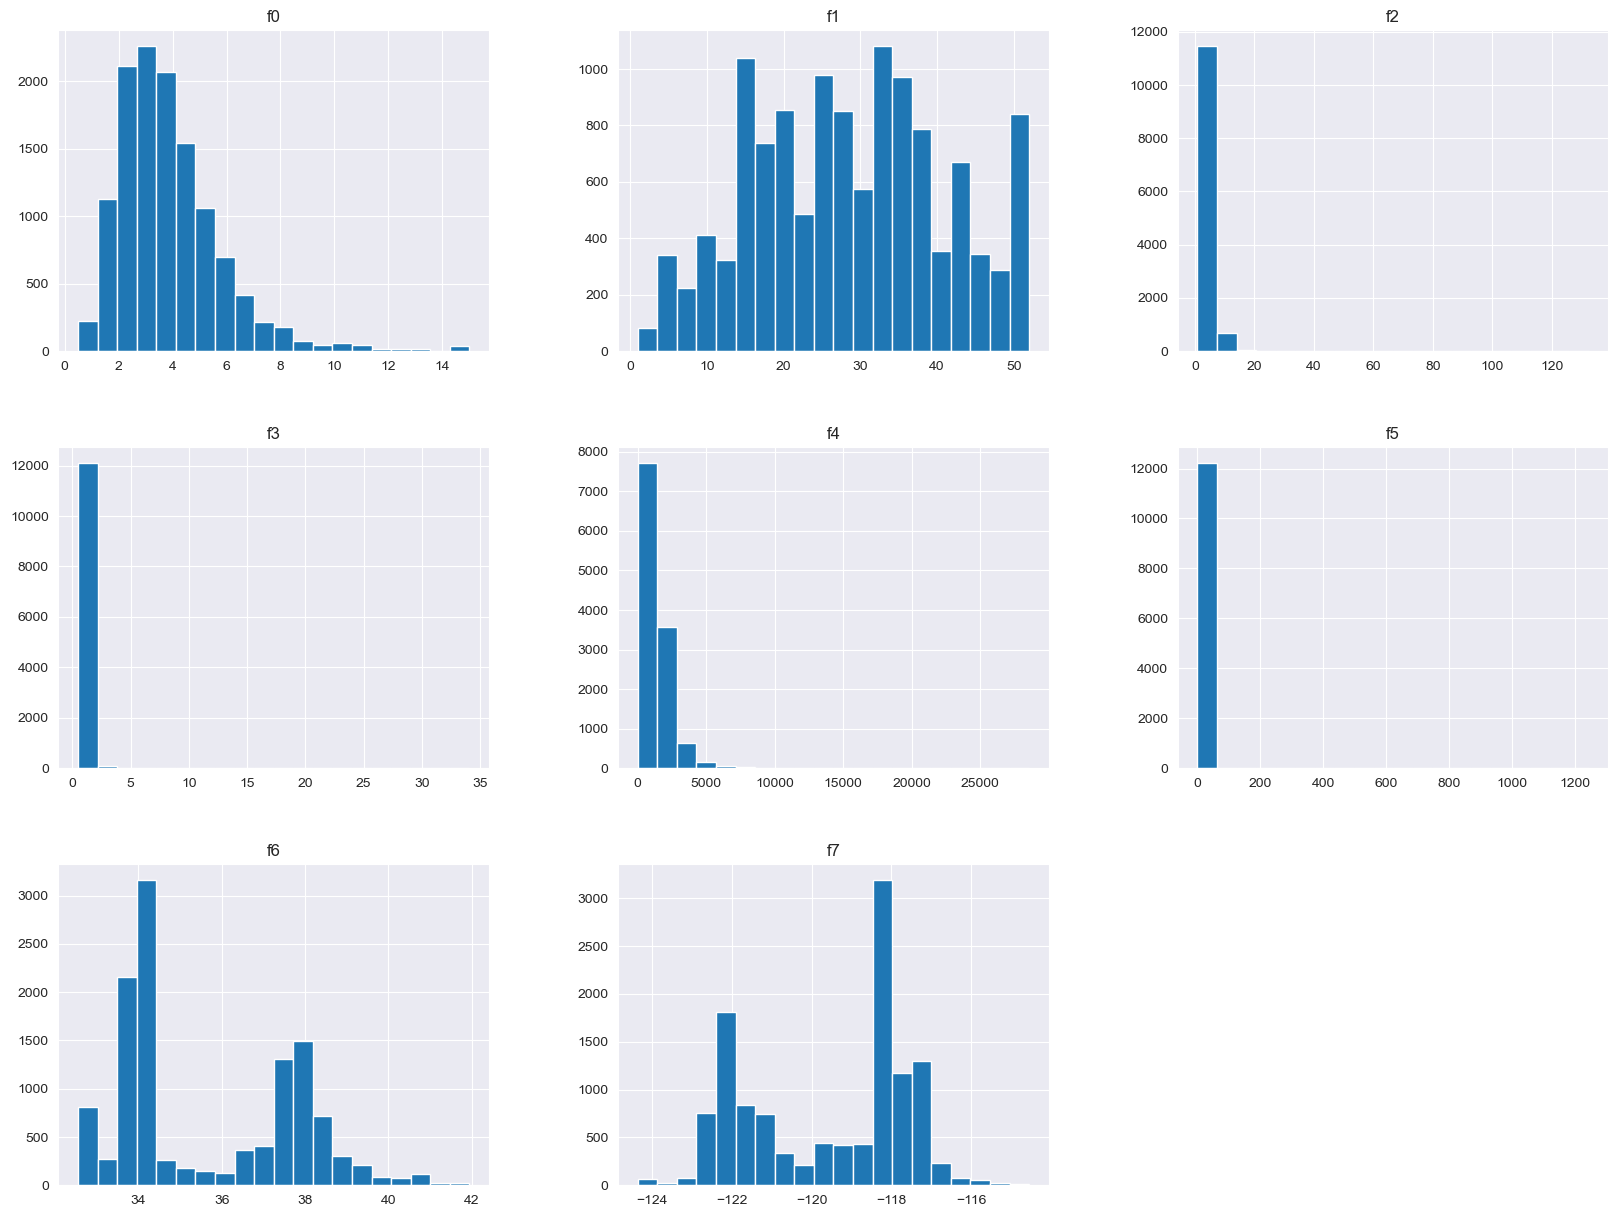

In [34]:
hist = X_train.hist(bins=20, figsize=(20, 15))
# TODO: fix this plot text size
# maybe create graphs separately for each feature to ensure its distribution is being captured correctly

The data range is very different between the features. We will deal with it in the preprocessing section, by scaling all the features to the same range.

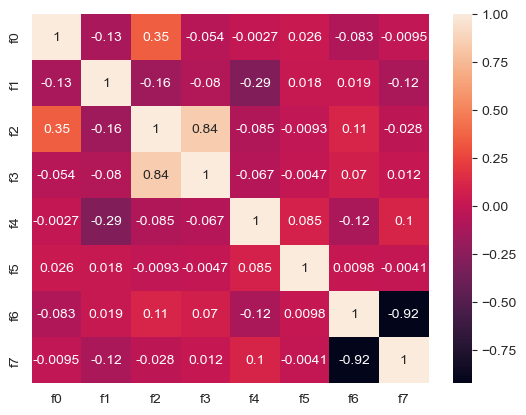

In [35]:
# check the correlation between the features
corr = X_train.corr()
sns.heatmap(corr, annot=True)
plt.show()

There is a positive correlation between f2 and f3 and a negetive correlation between f6 and f7, we might want to remove one of each pair in the preprocessing section or another method of exploiting this correlation.

In [42]:
def plot_feature_label_correlation(X: pd.DataFrame, y: pd.Series):
    # show correlation between each feature and the label
    all_correlations = []
    for col in X.columns:
        corr = X[col].corr(y)
        all_correlations.append(corr)
    # plot the correlation between each feature and the label
    plt.figure(figsize=(20, 10))

    # add title and labels
    plt.title('Correlation between each feature and the label')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    # plot the barplot
    sns.barplot(x=X.columns, y=all_correlations)
    return all_correlations

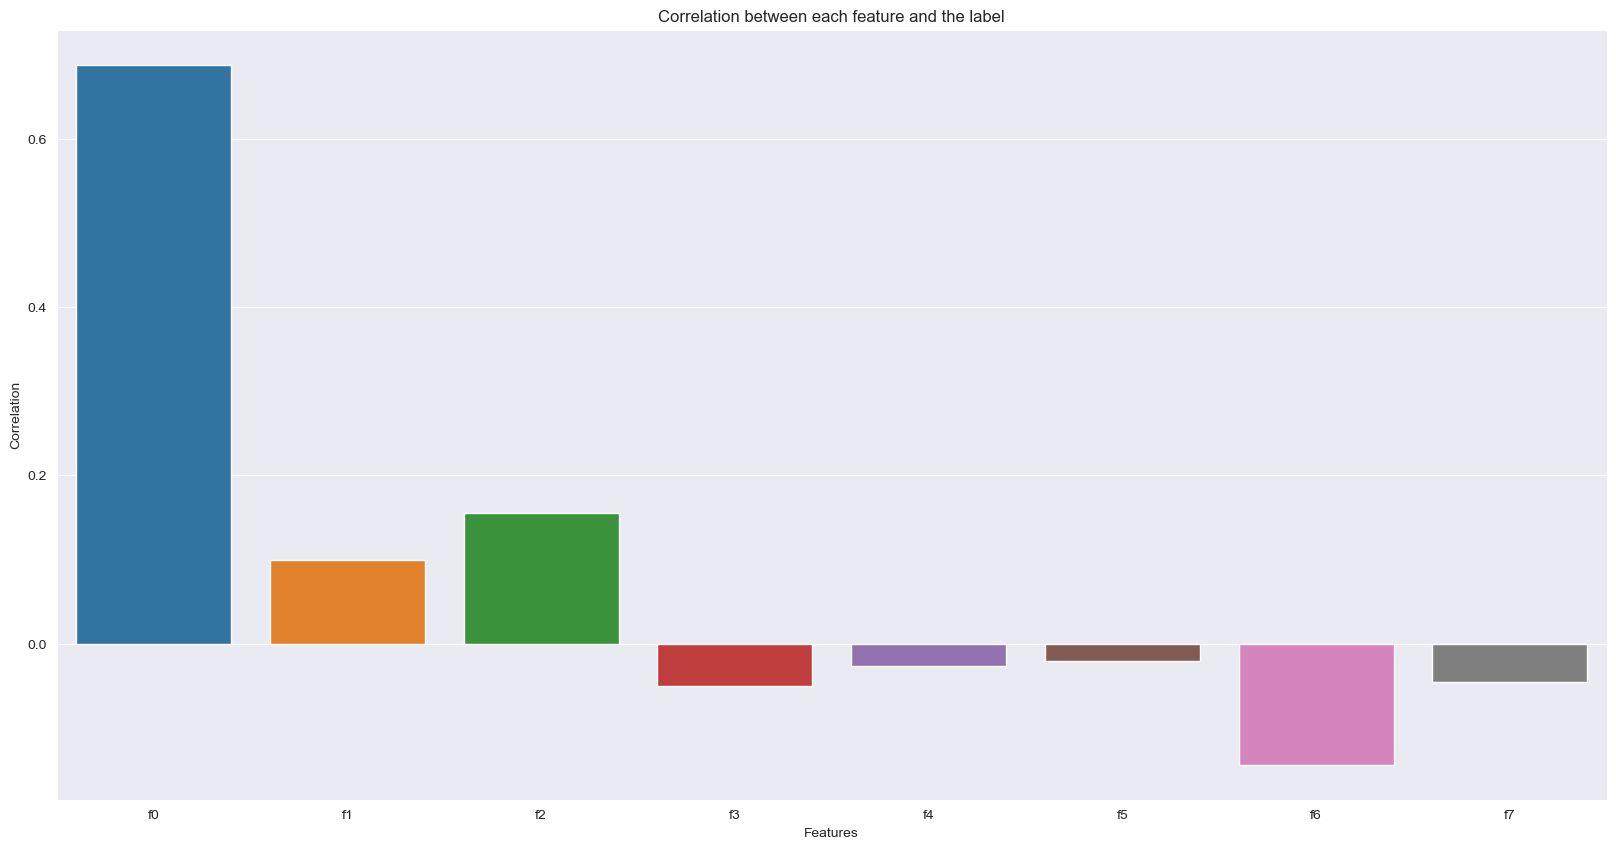

In [43]:
all_correlations = plot_feature_label_correlation(X_train, y_train)

f0 has a good correlation with the label, we might want to use it as a baseline.
# TODO: why does f2, f3 dont have the same correlation or similar? (same with f6 f7 but backwards)

# 3. Preprocessing
---
In this section, we will preprocess the data in order to improve the model's performance.
We will do the following:
- Create copies of our datasets and modify them instead of the original ones, to be able to compare results later.
- Remove features that are extremely not correlated with the label.
- Remove features that are almost always 0.

In [44]:
# TODO: currently skipped preprocessing, need to add it later after we decide our approaches according to the preliminary analysis
# TODO: think about dimensionality reduction (pca, tsne)

In [55]:
# add mean of features at missing values
X_train_mean = X_train.fillna(X_train.mean())

In [66]:
# change features mean to 0 and std to 1
X_train_norm = (X_train_mean - X_train_mean.mean()) / X_train_mean.std()
X_train_norm.describe()


,f0,f1,f2,f3,f4,f5,f6,f7
count,1.238400e+04,1.238400e+04,1.238400e+04,1.238400e+04,1.238400e+04,1.238400e+04,1.238400e+04,1.238400e+04
mean,1.595049e-16,-6.081842e-17,2.584783e-16,1.706932e-16,-2.295035e-18,-8.032621e-18,3.625868e-15,-2.282412e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.769931e+00,-2.211352e+00,-1.932507e+00,-1.273701e+00,-1.299149e+00,-1.835199e-01,-1.451000e+00,-2.412965e+00
25%,-6.853671e-01,-8.507954e-01,-4.140078e-01,-1.915076e-01,-5.801522e-01,-5.322866e-02,-7.954918e-01,-1.113007e+00
50%,-1.641805e-01,0.000000e+00,-7.839047e-02,-9.864261e-02,-2.243037e-01,-2.396320e-02,-6.398675e-01,5.245387e-01
75%,4.464506e-01,6.698263e-01,2.556544e-01,3.323773e-03,2.722874e-01,9.297052e-03,9.776825e-01,7.764687e-01
max,5.839121e+00,1.870317e+00,5.369509e+01,7.038574e+01,2.476265e+01,9.280649e+01,2.981935e+00,2.524863e+00


# 4. Trying different models on the original datasets
---
In this section, we will try different models on the original datasets, without any modifications to the models and compare their performance.


In [68]:
def choose_model_with_k_fold(models_list, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    all_models_scores = []
    for model in tqdm(models_list, desc="Trying models"):
        scores = cross_val_score(model, X, y, cv=kfold)
        score = scores.mean()
        all_models_scores.append(score)
    best_score_idx = np.argmax(all_models_scores)
    # print all models names and scores
    for i in range(len(models_list)):
        print(f"{models_list[i].__class__.__name__}: {all_models_scores[i]}")
    print("=====================================")
    print(f"Best score: {all_models_scores[best_score_idx]}")
    print(f"Best model: {models_list[best_score_idx].__class__.__name__}")
    return best_model

In [65]:
## trying several models on the original datasets
models_list = [
    KNeighborsRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor(),
    SVR(),
    # GaussianNB()
]
best_model = choose_model_with_k_fold(models_list, X_train_mean, y_train)

Trying models: 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]

KNeighborsRegressor: 0.07719951873878787
LinearRegression: 0.5813596611637987
Ridge: 0.5813856339218656
Lasso: 0.2726068701208737
DecisionTreeRegressor: 0.5586510136855767
RandomForestRegressor: 0.7817654467682544
AdaBoostRegressor: 0.4696912816513703
GradientBoostingRegressor: 0.7642679388846207
XGBRegressor: 0.8075073667780968
SVR: -0.036122163431290974
Best score: 0.8075073667780968
Best model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monoto

In [67]:
best_model_normalized = choose_model_with_k_fold(models_list, X_train_norm, y_train)

Trying models: 100%|██████████| 10/10 [01:53<00:00, 11.31s/it]

KNeighborsRegressor: 0.6481256848495356
LinearRegression: 0.5813596611637987
Ridge: 0.5813718725527306
Lasso: -0.0005270329713329414
DecisionTreeRegressor: 0.5579010839365485
RandomForestRegressor: 0.7814523200154467
AdaBoostRegressor: 0.4510481211378754
GradientBoostingRegressor: 0.7640946981175982
XGBRegressor: 0.807674626252205
SVR: 0.7014140157205278
Best score: 0.807674626252205
Best model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone

In [ ]:
#TODO: we should think about using the dev data to show the score of the models, and not the cross val score.
# Decide the next steps after preprocessing